In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from collections import Counter

%matplotlib inline

In [111]:
def process_file(file_id=100, nu_cut=1.0, beta=1.0, make_plot=False, randomize_peaks=False, randomize_pos=False):

    peak_name = "map{:d}_100deg2_sl2.5_GSN_peaks.txt".format(file_id)
    peak_file = os.path.join("../data/", peak_name)
    all_peak_data = np.loadtxt(peak_file)

    n = len(all_peak_data[:,0])
    ids = np.arange(n)
    
    # randomize the positions
    if randomize_pos:
        np.random.shuffle(ids)
        all_peak_data[:,1] = all_peak_data[ids,1]
        np.random.shuffle(ids)
        all_peak_data[:,2] = all_peak_data[ids,2]
    
    # randomize the significance values
    if randomize_peaks:
        np.random.shuffle(ids)
        all_peak_data[:,0] = all_peak_data[ids,0]
    
    # significance cut
    ii = all_peak_data[:,0]> nu_cut
    peak_data = all_peak_data[ii]
    print(len(peak_data))
    print(len(all_peak_data))
    if randomize_peaks and not randomize_pos:
        out_filename = "../data/beta_randpeaks_{:.2f}_nu_{:.2f}_{}".format(beta, nu_cut, peak_name)
        peak_pos_file = peak_file.replace("map", "pos_randpeaks_nu_{:.2f}_".format(nu_cut))
    if randomize_pos and not randomize_peaks:
        out_filename = "../data/beta_randpos_{:.2f}_nu_{:.2f}_{}".format(beta, nu_cut, peak_name)
        peak_pos_file = peak_file.replace("map", "pos_randpos_nu_{:.2f}_".format(nu_cut))
    if randomize_peaks and randomize_pos:
        out_filename = "../data/beta_randpeakspos_{:.2f}_nu_{:.2f}_{}".format(beta, nu_cut, peak_name)
        peak_pos_file = peak_file.replace("map", "pos_randpeakpos_nu_{:.2f}_".format(nu_cut))
    if not randomize_peaks and not randomize_pos:
        out_filename = "../data/beta_{:.2f}_nu_{:.2f}_{}".format(beta, nu_cut, peak_name)
        peak_pos_file = peak_file.replace("map", "pos_nu_{:.2f}_".format(nu_cut))  
    print(peak_pos_file)
    # save data with the cuts
    if not os.path.exists(peak_pos_file):
        np.savetxt(peak_pos_file, peak_data[:,1:])
    
    skel = "/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph "

    if not os.path.exists(out_filename):
        cmd = "{} -d 2 -i {} -b {} -o > {}".format(skel, peak_pos_file, beta, out_filename)
        print(cmd)
        os.system(cmd)
    
    # read in the pairs
    point_data = np.loadtxt(peak_pos_file)
    beta_data = np.int_(np.loadtxt(out_filename))
    print(len(point_data))
    # remove the duplicate points using the fact that the first column is ordered in ngl-beta
    ii = beta_data[:,0]<beta_data[:,1]
    beta_data = beta_data[ii]

    n_points = len(point_data)
    #print(n_points)

    # Flattend and count links
    beta_data_flat = beta_data.flatten()
    beta_link_count = Counter(Counter(beta_data_flat).values())

    # Count how many points have zero links
    unique_beta_id = len(set(beta_data_flat))
    if (n_points - unique_beta_id)>0:
        beta_link_count[0] = n_points - unique_beta_id

    assert np.sum(list(beta_link_count.values()))==n_points
    # compute probability array
    proba = []
    total_link = np.sum(list(beta_link_count.values()))
    for k in beta_link_count:
        #print(k, beta_link_count[k]/total_link)
        proba.append(beta_link_count[k]/total_link)
    proba = np.array(proba)
    print(proba, proba.sum())
    entropy = np.sum(-proba*np.log(proba)/np.log10(2))
    #print('Entropy', entropy)
    mean_connections = len(beta_data)/len(point_data)
    #print('Mean connections', mean_connections)

    # compute the distances
    delta_x  = point_data[beta_data[:,0],0] - point_data[beta_data[:,1],0]
    delta_y = point_data[beta_data[:,0],1] - point_data[beta_data[:,1],1]
    distance = np.sqrt(delta_x**2 + delta_y**2)
    #_ = plt.hist(distance)
    mean_distance = np.mean(distance)

    # plot the skeleton
    if make_plot:
        title = r"$\beta={:.1f}$, $\nu>{:.1f}$, Entropy={:.2f} Sh, $\langle l\rangle = {:.2f}$, $\kappa={:.1f}$".format(
            beta, nu_cut, entropy, mean_distance, mean_connections)
        plt.figure(figsize=(8,8))
        for p in beta_data:
            #print(p)
            plt.plot(point_data[p,0], point_data[p,1], c='black')
        #plt.scatter(all_peak_data[:,1], all_peak_data[:,2],c=all_peak_data[:,0], alpha=0.8, cmap='tab10')
        plt.scatter(point_data[:,0], point_data[:,1],c='black')
        plt.axis('scaled')
        plt.title(title)
    return {'entropy':entropy, 'mean_distance':mean_distance, 'mean_connections':mean_connections, 
            'beta':beta, 'nu_cut':nu_cut, 'file_id':file_id}

In [112]:
def plot_summary(summary_data):
    ii = summary_data['nu_cut']==1.5
    jj = summary_data['nu_cut']==2.5
    kk = summary_data['nu_cut']==3.5

    print(set(summary_data['nu_cut']))
    plt.figure(figsize=(14,8))
    plt.subplot(2,3,1)
    plt.scatter(summary_data['beta'][ii], summary_data['entropy'][ii])
    plt.scatter(summary_data['beta'][jj], summary_data['entropy'][jj], alpha=0.4)
    plt.scatter(summary_data['beta'][kk], summary_data['entropy'][kk], alpha=0.4)
    plt.ylabel('Entropy')
    plt.xlabel(r'$\beta$')

    plt.subplot(2,3,2)
    plt.scatter(summary_data['beta'][ii], summary_data['mean_connections'][ii])
    plt.scatter(summary_data['beta'][jj], summary_data['mean_connections'][jj], alpha=0.4)
    plt.scatter(summary_data['beta'][kk], summary_data['mean_connections'][kk], alpha=0.4)
    plt.ylabel('mean number of connections')
    plt.xlabel(r'$\beta$')

    plt.subplot(2,3,3)
    plt.scatter(summary_data['beta'][ii], summary_data['mean_dist'][ii])
    plt.scatter(summary_data['beta'][jj], summary_data['mean_dist'][jj], alpha=0.4)
    plt.scatter(summary_data['beta'][kk], summary_data['mean_dist'][kk], alpha=0.4)
    plt.ylabel('Average connection length')
    plt.xlabel(r'$\beta$')
    
    ii = summary_data['beta']==1.0
    jj = summary_data['beta']==2.0
    kk = summary_data['beta']==3.0

    print(set(summary_data['nu_cut']))
    plt.subplot(2,3,4)
    plt.scatter(summary_data['nu_cut'][ii], summary_data['entropy'][ii])
    plt.scatter(summary_data['nu_cut'][jj], summary_data['entropy'][jj], alpha=0.4)
    plt.scatter(summary_data['nu_cut'][kk], summary_data['entropy'][kk], alpha=0.4)
    plt.ylabel('Entropy')
    plt.xlabel(r'$\nu$')

    plt.subplot(2,3,5)
    plt.scatter(summary_data['nu_cut'][ii], summary_data['mean_connections'][ii])
    plt.scatter(summary_data['nu_cut'][jj], summary_data['mean_connections'][jj], alpha=0.4)
    plt.scatter(summary_data['nu_cut'][kk], summary_data['mean_connections'][kk], alpha=0.4)
    plt.ylabel('mean number of connections')
    plt.xlabel(r'$\nu$')

    plt.subplot(2,3,6)
    plt.scatter(summary_data['nu_cut'][ii], summary_data['mean_dist'][ii])
    plt.scatter(summary_data['nu_cut'][jj], summary_data['mean_dist'][jj], alpha=0.4)
    plt.scatter(summary_data['nu_cut'][kk], summary_data['mean_dist'][kk], alpha=0.4)
    plt.ylabel('Average connection length')
    plt.xlabel(r'$\nu$')

1013
2206
../data/pos_nu_1.00_100_100deg2_sl2.5_GSN_peaks.txt
1013
[0.03751234 0.47384008 0.43830207 0.05034551] 1.0


{'beta': 2.0,
 'entropy': 3.2856112451042536,
 'file_id': 100,
 'mean_connections': 1.2685093780848964,
 'mean_distance': 0.2528113536790604,
 'nu_cut': 1.0}

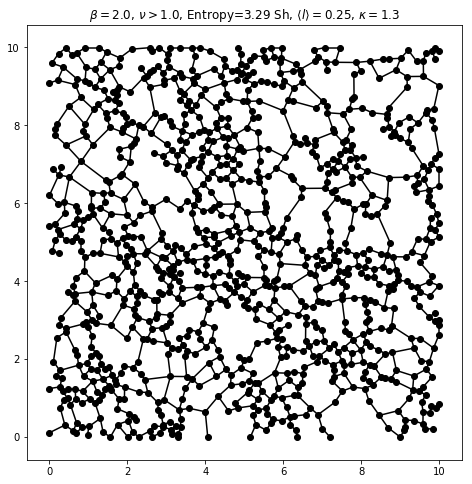

In [116]:
process_file(nu_cut=1.0, beta=2.0, make_plot=True)

365
2206
../data/pos_nu_2.00_100_100deg2_sl2.5_GSN_peaks.txt
365
[0.06027397 0.49315068 0.41643836 0.03013699] 1.0


{'beta': 2.0,
 'entropy': 3.282981261594302,
 'file_id': 100,
 'mean_connections': 1.2082191780821918,
 'mean_distance': 0.39529420512590197,
 'nu_cut': 2.0}

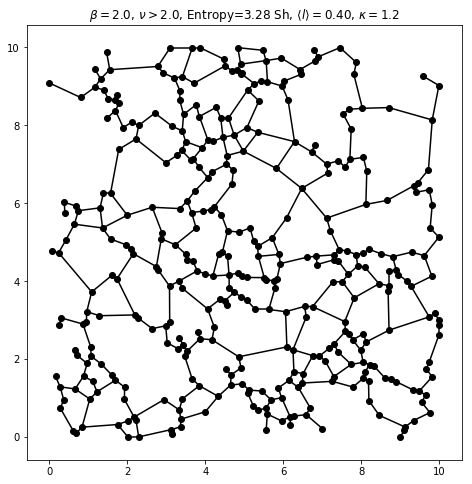

In [117]:
process_file(nu_cut=2.0, beta=2.0, make_plot=True)

365
2206
../data/pos_randpos_nu_2.00_100_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpos_nu_2.00_100_100deg2_sl2.5_GSN_peaks.txt -b 2.0 -o > ../data/beta_randpos_2.00_nu_2.00_map100_100deg2_sl2.5_GSN_peaks.txt
365
[0.03561644 0.48493151 0.44383562 0.03561644] 1.0


{'beta': 2.0,
 'entropy': 3.152689435495115,
 'file_id': 100,
 'mean_connections': 1.2602739726027397,
 'mean_distance': 0.4361949746037241,
 'nu_cut': 2.0}

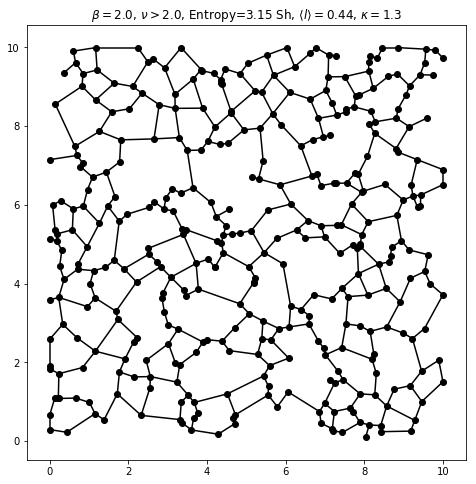

In [118]:
process_file(nu_cut=2.0, beta=2.0, make_plot=True, randomize_pos=True)

365
2206
../data/pos_randpeakpos_nu_2.00_100_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeakpos_nu_2.00_100_100deg2_sl2.5_GSN_peaks.txt -b 2.0 -o > ../data/beta_randpeakspos_2.00_nu_2.00_map100_100deg2_sl2.5_GSN_peaks.txt
365
[0.47671233 0.45205479 0.05479452 0.01643836] 1.0


{'beta': 2.0,
 'entropy': 3.1184322997854808,
 'file_id': 100,
 'mean_connections': 1.2273972602739727,
 'mean_distance': 0.420908122226239,
 'nu_cut': 2.0}

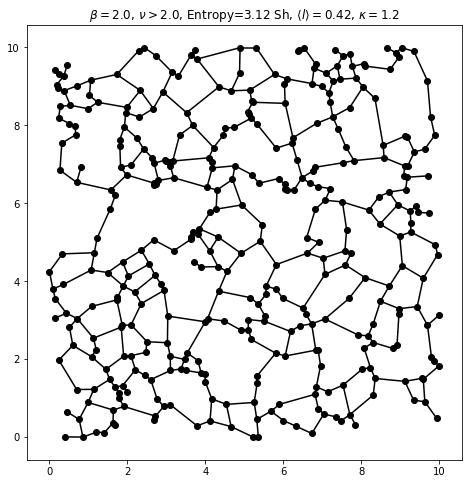

In [119]:
process_file(nu_cut=2.0, beta=2.0, make_plot=True, randomize_pos=True, randomize_peaks=True)

In [120]:
beta_values = np.linspace(1.0, 3.0 , 9)
nu_cut_values = np.linspace(1.5, 3.5, 9)
file_id_values = np.arange(5)

outfile = open("../data/summary.txt", "w")
outfile.write("# file_id nu_cut beta entropy mean_dist mean_connections\n")
for file_id in file_id_values:
    for nu_cut in nu_cut_values:
        for beta in beta_values:
            results = process_file(file_id=file_id, nu_cut=nu_cut, beta=beta)
            outfile.write("{:d}\t".format(results['file_id']))
            outfile.write("{:.2f}\t".format(results['nu_cut']))
            outfile.write("{:.2f}\t".format(results['beta']))
            outfile.write("{:.2f}\t".format(results['entropy']))
            outfile.write("{:.2f}\t".format(results['mean_distance']))
            outfile.write("{:.2f}\t".format(results['mean_connections']))

            outfile.write("\n")
outfile.close()

545
2223
../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.0 -o > ../data/beta_1.00_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.06055046 0.38715596 0.27889908 0.20183486 0.04954128 0.00917431
 0.00366972 0.00917431] 1.0
545
2223
../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.25 -o > ../data/beta_1.25_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.01284404 0.15412844 0.32110092 0.43486239 0.06605505 0.00366972
 0.00733945] 1.0
545
2223
../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.5 -o > ../data/beta_1.50_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.01651376 0.25504587 0.48623853 0.2

In [121]:
beta_values = np.linspace(1.0, 3.0 , 9)
nu_cut_values = np.linspace(1.5, 3.5, 9)
file_id_values = np.arange(5)

outfile = open("../data/summary_randomized_pos.txt", "w")
outfile.write("# file_id nu_cut beta entropy mean_dist mean_connections\n")
for file_id in file_id_values:
    for nu_cut in nu_cut_values:
        for beta in beta_values:
            results = process_file(file_id=file_id, nu_cut=nu_cut, beta=beta, randomize_pos=True)
            outfile.write("{:d}\t".format(results['file_id']))
            outfile.write("{:.2f}\t".format(results['nu_cut']))
            outfile.write("{:.2f}\t".format(results['beta']))
            outfile.write("{:.2f}\t".format(results['entropy']))
            outfile.write("{:.2f}\t".format(results['mean_distance']))
            outfile.write("{:.2f}\t".format(results['mean_connections']))

            outfile.write("\n")
outfile.close()

545
2223
../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.0 -o > ../data/beta_randpos_1.00_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.30275229 0.2146789  0.33027523 0.05688073 0.01284404 0.08073394
 0.00183486] 1.0
545
2223
../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.25 -o > ../data/beta_randpos_1.25_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.42385321 0.08990826 0.31559633 0.14678899 0.01651376 0.00733945] 1.0
545
2223
../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.5 -o > ../data/beta_randpos_1.50_nu_1.50_map0_100deg2_sl2.5_GSN_pe

In [122]:
beta_values = np.linspace(1.0, 3.0 , 9)
nu_cut_values = np.linspace(1.5, 3.5, 9)
file_id_values = np.arange(5)

outfile = open("../data/summary_randomized_peaks.txt", "w")
outfile.write("# file_id nu_cut beta entropy mean_dist mean_connections\n")
for file_id in file_id_values:
    for nu_cut in nu_cut_values:
        for beta in beta_values:
            results = process_file(file_id=file_id, nu_cut=nu_cut, beta=beta, randomize_peaks=True)
            outfile.write("{:d}\t".format(results['file_id']))
            outfile.write("{:.2f}\t".format(results['nu_cut']))
            outfile.write("{:.2f}\t".format(results['beta']))
            outfile.write("{:.2f}\t".format(results['entropy']))
            outfile.write("{:.2f}\t".format(results['mean_distance']))
            outfile.write("{:.2f}\t".format(results['mean_connections']))

            outfile.write("\n")
outfile.close()

545
2223
../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.0 -o > ../data/beta_randpeaks_1.00_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.06238532 0.24587156 0.42752294 0.17981651 0.06422018 0.0146789
 0.00183486 0.00366972] 1.0
545
2223
../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.25 -o > ../data/beta_randpeaks_1.25_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.12844037 0.41651376 0.35045872 0.07889908 0.00917431 0.0146789
 0.00183486] 1.0
545
2223
../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeaks_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.5 -o > ../data/beta_randpeaks

In [123]:
beta_values = np.linspace(1.0, 3.0 , 9)
nu_cut_values = np.linspace(1.5, 3.5, 9)
file_id_values = np.arange(5)

outfile = open("../data/summary_randomized_peakspos.txt", "w")
outfile.write("# file_id nu_cut beta entropy mean_dist mean_connections\n")
for file_id in file_id_values:
    for nu_cut in nu_cut_values:
        for beta in beta_values:
            results = process_file(file_id=file_id, nu_cut=nu_cut, beta=beta, randomize_peaks=True, randomize_pos=True)
            outfile.write("{:d}\t".format(results['file_id']))
            outfile.write("{:.2f}\t".format(results['nu_cut']))
            outfile.write("{:.2f}\t".format(results['beta']))
            outfile.write("{:.2f}\t".format(results['entropy']))
            outfile.write("{:.2f}\t".format(results['mean_distance']))
            outfile.write("{:.2f}\t".format(results['mean_connections']))

            outfile.write("\n")
outfile.close()

545
2223
../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.0 -o > ../data/beta_randpeakspos_1.00_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.35779817 0.08990826 0.18165138 0.03669725 0.32293578 0.00550459
 0.00183486 0.00366972] 1.0
545
2223
../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt -b 1.25 -o > ../data/beta_randpeakspos_1.25_nu_1.50_map0_100deg2_sl2.5_GSN_peaks.txt
545
[0.29908257 0.19266055 0.06788991 0.42752294 0.00183486 0.00366972
 0.00733945] 0.9999999999999999
545
2223
../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt
/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph  -d 2 -i ../data/pos_randpeakpos_nu_1.50_0_100deg2_sl2.5_GSN_peaks.txt

In [124]:
summary ={}
dtype=[('file_id', 'i8'), ('nu_cut', 'f8'), ('beta', 'f8'), ('entropy', 'f8'), ('mean_dist', 'f8'), ('mean_connections', 'f8')]
summary['normal'] = np.loadtxt("../data/summary.txt", dtype=dtype)
summary['rand_peak'] = np.loadtxt("../data/summary_randomized_peaks.txt", dtype=dtype)
summary['rand_pos'] = np.loadtxt("../data/summary_randomized_pos.txt", dtype=dtype)
summary['rand_peakpos'] = np.loadtxt("../data/summary_randomized_peakspos.txt", dtype=dtype)

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}
{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


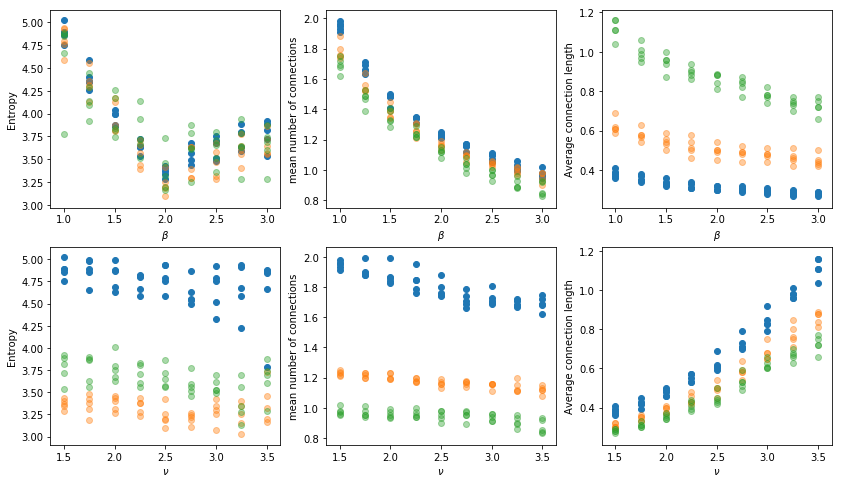

In [125]:
plot_summary(summary['normal'])

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}
{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


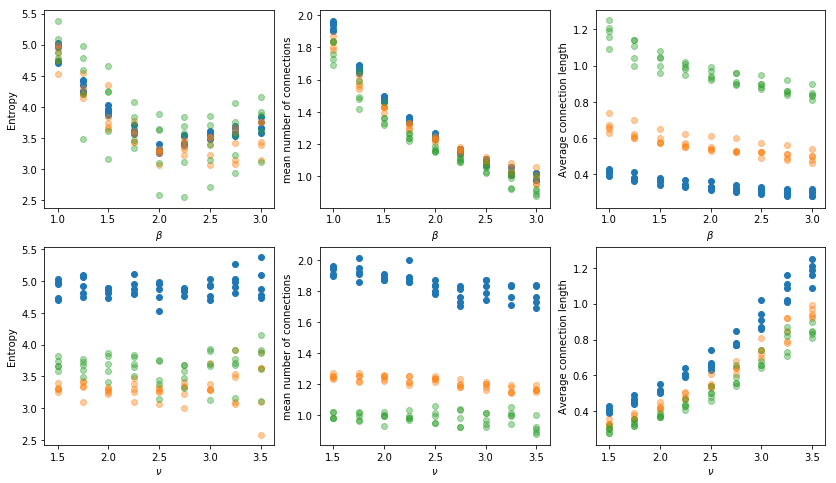

In [126]:
plot_summary(summary['rand_pos'])

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}
{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


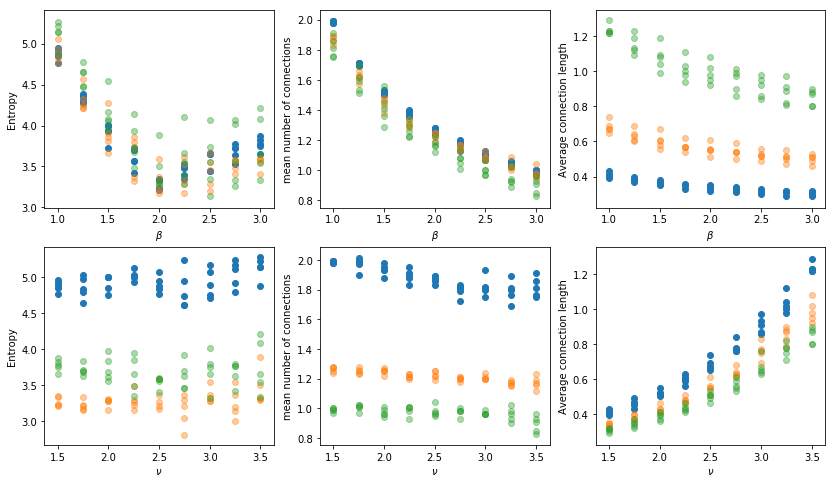

In [127]:
plot_summary(summary['rand_peak'])

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}
{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


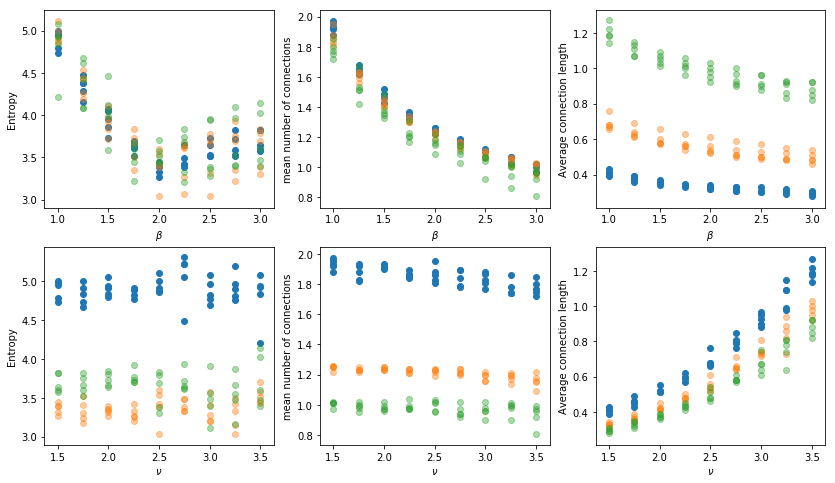

In [128]:
plot_summary(summary['rand_peakpos'])